In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings

warnings.filterwarnings(action = 'ignore')

# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [4]:
#데이터 불러오기
fashion=pd.read_csv('fashion-mnist.csv') #경로수정
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [5]:
fashion.shape

(60000, 785)

In [6]:
# fashion data 6,000개 사용
# train : test = approximately 8 : 2

fashion = fashion.loc[:6000, :]

rnd = np.random.uniform(size = (len(fashion), )) < 0.8

train = fashion[rnd]
test = fashion[~rnd]

In [7]:
print(len(train))
print(len(test))

4850
1151


In [8]:
X_train = train.drop('label', axis = 1).reset_index(drop = True)
y_train = train.loc[:, 'label'].reset_index(drop = True)
X_test = test.drop('label', axis = 1).reset_index(drop = True)
y_test = test.loc[:, 'label'].reset_index(drop = True)

del fashion; del train; del test

- 어떻게 생긴 데이터셋인지 확인해보기

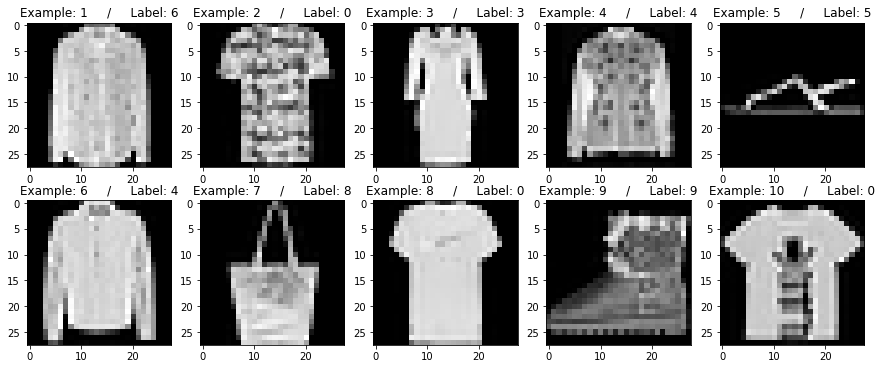

In [9]:
plt.figure(figsize = (15, 6))

for _ in range(1, 11):
    plt.subplot(2, 5, _)
    label = y_train.loc[_]
    image = X_train.loc[_, :].values.reshape([28, 28])
    
    plt.imshow(image, cmap = plt.get_cmap('gray'))
    plt.title('Example: %d     /     Label: %d'%(_, label))
    
plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 784)
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA.shape

(4850, 784)

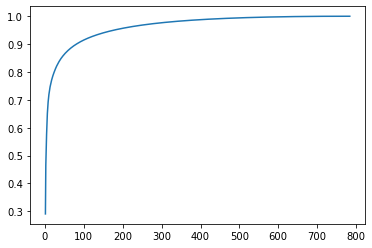

In [11]:
cumul = []
cnt = 0

for _ in range(784):
    cnt += pca.explained_variance_ratio_[_]
    cumul.append(cnt)
    
plt.plot(range(1, 785), cumul)
plt.show()

In [12]:
print(np.where(np.array(cumul) > 0.8)[0][0])
# 기준으로 선택
print(np.where(np.array(cumul) > 0.85)[0][0])
print(np.where(np.array(cumul) > 0.9)[0][0])

23
41
80


- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


In [13]:
pca = PCA(n_components = 41)

X_train_PCA = pca.fit_transform(X_train) 
X_test_PCA = pca.transform(X_test) 

print('Original space:',X_train.shape)
print('After PCA:',X_train_PCA.shape)

Original space: (4850, 784)
After PCA: (4850, 41)


In [17]:
# 784-dimension XGBoost

from xgboost import XGBClassifier

start = time.time()

xgboost = XGBClassifier()

xgboost.fit(X_train, y_train)

print('train f1-score :',f1_score(y_train, xgboost.predict(X_train), average = 'weighted'))
print('test f1-score :',f1_score(y_test, xgboost.predict(X_test), average = 'weighted'))

print(f'{time.time() - start:.3f} seconds')

train f1-score : 1.0
test f1-score : 0.8753377072431694
73.660 seconds


In [18]:
# 41-dimension PCA-XGBoost

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

start = time.time()

xgboost = XGBClassifier()

xgboost.fit(X_train_PCA, y_train)

print('train f1-score :',f1_score(y_train, xgboost.predict(X_train_PCA),
                                  average = 'weighted'))
print('test f1-score :',f1_score(y_test, xgboost.predict(X_test_PCA),
                                 average = 'weighted'))

print(f'{time.time() - start:.3f} seconds')

train f1-score : 1.0
test f1-score : 0.859548725797727
14.650 seconds


* 학습 속도가 73.6s -> 14.6s으로 1/6으로 감소하면서 test f1-score은 0.875에서 0.859으로 미세한 차이를 보이고 있습니다.
* PCA를 사용함으로 더 빠른 학습 속도로 비슷한 성능을 얻을 수 있음을 확인 가능합니다.

# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

In [19]:
# 데이터의 클래스를 잘 구분하는 LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

start=time.time()

lda = LinearDiscriminantAnalysis(n_components = 2)
X_train_lda = lda.fit_transform(X_train, y_train)

print(f'{time.time() - start:.3f}sec')

2.110sec


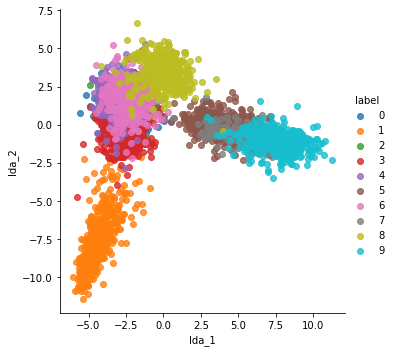

In [20]:
X_train_lda = pd.DataFrame(X_train_lda).loc[:, 0:1]
X_train_lda = pd.concat((X_train_lda, y_train), axis = 1) 
X_train_lda.columns = ['lda_1', 'lda_2', 'label']

sns.lmplot(x = 'lda_1', y = 'lda_2',data = X_train_lda,
           hue = 'label', fit_reg = False)

plt.show()

In [41]:
# KPCA = 커널 함수를 이용해 고차원에서 PCA를 진행

from sklearn.decomposition import KernelPCA

start=time.time()

rbf_pca = KernelPCA(n_components = 2, kernel = "rbf",
                    gamma = 50, fit_inverse_transform = True)

X_train_rbf_pca = rbf_pca.fit_transform(X_train)

print(f'{time.time() - start:.4f}sec')

14.4220sec


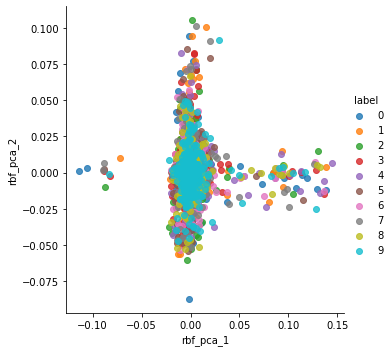

In [42]:
X_train_rbf_pca = pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca = pd.concat((X_train_rbf_pca, y_train), axis = 1) 
X_train_rbf_pca.columns = ['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',
           fit_reg=False)
plt.show()

In [25]:
# 곡선거리를 기준으로 한 지오데식 거리를 보존하는 Isomap
from sklearn.manifold import Isomap
start = time.time()

isomap = Isomap(n_neighbors = 5, n_components = 2,n_jobs = 4)         
X_train_isomap = isomap.fit_transform(X_train)

print(f'{time.time()-start:.4f}sec')

42.5728sec


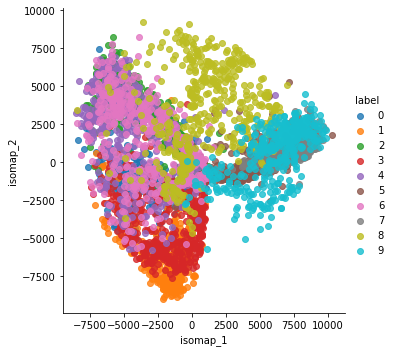

In [26]:
X_train_isomap = pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap = pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns = ['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',
           fit_reg=False)
plt.show()

In [27]:
# 주변 이웃들의 관계를 저차원에서 유지하는 LLE
from sklearn.manifold import LocallyLinearEmbedding

start=time.time()
lle = LocallyLinearEmbedding(n_components = 2, random_state = 42)
X_train_lle = lle.fit_transform(X_train)

print(f'{time.time()-start:.4f}sec')

4.2834sec


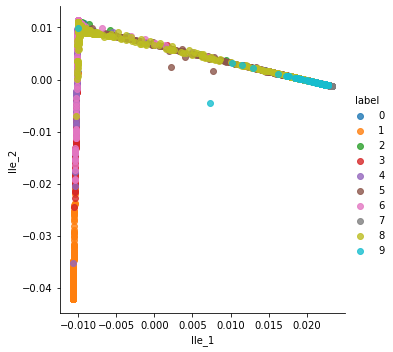

In [28]:
X_train_lle=pd.DataFrame(X_train_lle).loc[:,0:1]
X_train_lle=pd.concat((X_train_lle, y_train), axis=1) 
X_train_lle.columns=['lle_1', 'lle_2', 'label']
X_train_lle

sns.lmplot(x='lle_1',y='lle_2',data=X_train_lle,hue='label',fit_reg=False)
plt.show()

In [29]:
# t-SNE = 주번 이웃들과의 확률적 관계를 그대로 유지
from sklearn.manifold import TSNE
start=time.time()

tsne = TSNE(n_components = 2, random_state=42) #4미만의 공간으로
X_train_tsne = tsne.fit_transform(X_train)

print(f'{time.time()-start:.4f}sec')

48.9918sec


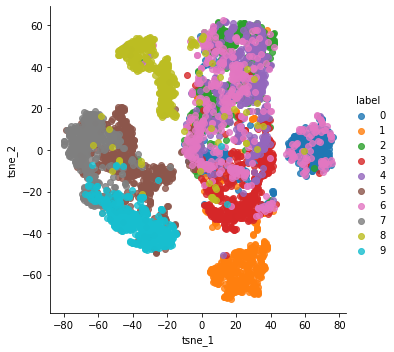

In [30]:
X_train_tsne=pd.DataFrame(X_train_tsne).loc[:,0:1]
X_train_tsne=pd.concat((X_train_tsne, y_train), axis=1) 
X_train_tsne.columns=['tsne_1', 'tsne_2', 'label']
X_train_tsne

sns.lmplot(x = 'tsne_1',y = 'tsne_2',data=X_train_tsne,
           hue = 'label',fit_reg = False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

> Q4 에서 시도한 방법 중 t-SNE으로 차원을 축소한 결과가 우수한 성능을 보입니다.<br>
> 그 이유로는 784 차원의 고차원 비선형 데이터에서 이웃들과의 관계를<br>
> 확률로 나타냄으로, 다른 데이터와의 관계를 제외하지 않으면서<br>
> 저차원으로 확률분포를 옮기기에도 용이합니다.

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

> 반면에 가우시안 방사 기저 함수 커널 (rbf) PCA는 저조한 성능을 보입니다.<br>
> 그 이유로는 고차원에서 커널 트릭으로 선형결합을 진행해도,<br>
> 원본 데이터의 기하학적 구조를 반영하지 못한 유클리디안 거리의<br>
> 한계점이 발생하기 때문입니다.

수고하셨습니다~